#### What does Sumcheck prove?

For a polynomial `f : 𝔽² → 𝔽` (here `n = 3`) given *as a black box*,  
the Prover wants to convince the Verifier that
$$
S = \sum_{x \in \{0,1\}^3} f(x) \quad (= 36 \text{ in our example})
$$





without sending all `2ⁿ` evaluations.  
Sumcheck does it in *n* rounds:

1. **Round i** Prover sends a univariate degree-≤ d polynomial `gᵢ`.  
2. Verifier checks `gᵢ(0)+gᵢ(1) = claimed_sum`.  
3. Verifier samples a random field element `rᵢ` and sends it back.  
4. Both parties restrict `f` to that slice and continue with `n − i − 1` variables.

Soundness error ≤ `d/|𝔽|` per round.  (We use plain integers for clarity.)


evaluations=  [1, 2, 3, 4, 5, 6, 7, 8]
MLE polynomial in evaluation form:

a[0] = 1 => term = 1*(-(X0 - 1)*(X1 - 1)*(X2 - 1))
a[1] = 2 => term = 2*((X0 - 1)*(X1 - 1)*X2)
a[2] = 3 => term = 3*((X0 - 1)*X1*(X2 - 1))
a[3] = 4 => term = 4*(-(X0 - 1)*X1*X2)
a[4] = 5 => term = 5*(X0*(X1 - 1)*(X2 - 1))
a[5] = 6 => term = 6*(-X0*(X1 - 1)*X2)
a[6] = 7 => term = 7*(-X0*X1*(X2 - 1))
a[7] = 8 => term = 8*(X0*X1*X2)

Expanded polynomial:
4⋅X₀ + 2⋅X₁ + X₂ + 1


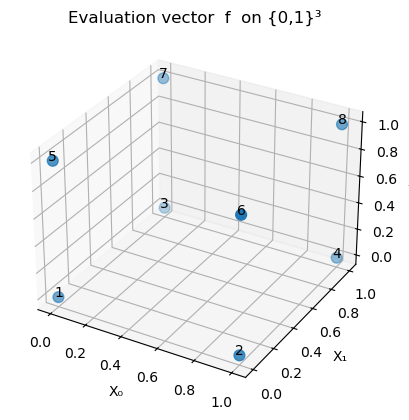


── First-round Sumcheck polynomial  h₁(X) ──
h₁(X) = 16  +  4·X
h₁(0) = 16        (even-half sum)
h₁(1) = 20    (odd-half  sum)
h₁(2) = 24  (third evaluation sent to the verifier)


In [70]:

import matplotlib.pyplot as plt
import sympy as sp
from mpl_toolkits.mplot3d import Axes3D   


def bits_of(i: int, n: int = 3):
    """Return the n-bit little-endian tuple of i (e.g. 5 → (1,0,1))."""
    return tuple((i >> j) & 1 for j in range(n))

f_vec = [1, 2, 3, 4, 5, 6, 7, 8]               # f(0,0,0) … f(1,1,1)
print("evaluations= ", f_vec)

X = sp.symbols(f'X0:{n}')               # (X0, X1, X2)

def bits(i, n):
    "Return i as an n-bit *list* (big-endian)."
    return list(map(int, format(i, f'0{n}b')))

def bits_reverse(i, n):
    "Little-endian version (least-significant bit first)."
    return bits(i, n)[::-1]

def eq_tilde(bits_i, u_vector):
    result=1
    for bit,u in zip(bits_i,u_vector):
        result *= (1-bit)*(1-u) + bit*u
    return result

N = len(f_vec)

print("MLE polynomial in evaluation form:\n")
for i in range(N):
    term = eq_tilde(bits(i, n), X)
    print(f"a[{i}] = {f_vec[i]} => term = {f_vec[i]}*({term})")

print("\nExpanded polynomial:")
sp.pretty_print(sp.expand(f_tilde))

coords  = [bits_of(i, 3) for i in range(8)]   

# 3-D scatter plot
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
xs, ys, zs = zip(*coords)

ax.scatter(xs, ys, zs, s=60)

# annotate each vertex with its f-value
for (x0, x1, x2), val in zip(coords, f_vec):
    ax.text(x0, x1, x2, f"{val}", fontsize=10, ha='center')

ax.set_xlabel("X₀")
ax.set_ylabel("X₁")
ax.set_zlabel("X₂")
ax.set_title("Evaluation vector  f  on {0,1}³")

plt.show()

# first-round h₁(X) polynomial

# Even half  (X₀ = 0)
g1_0 = sum(f_vec[idx] for idx in range(8) if bits_of(idx)[0] == 0)
# Odd  half  (X₀ = 1)
g1_1 = sum(f_vec[idx] for idx in range(8) if bits_of(idx)[0] == 1)

# h₁(X) = a + b·X
a = g1_0
b = g1_1 - g1_0

print("\n── First-round Sumcheck polynomial  h₁(X) ──")
print(f"h₁(X) = {a}  +  {b}·X")
print(f"h₁(0) = {a}        (even-half sum)")
print(f"h₁(1) = {a + b}    (odd-half  sum)")
print(f"h₁(2) = {a + 2*b}  (third evaluation sent to the verifier)")




Verifier samples  α₀ = 8

Folded 4-point vector  f¹  on the (X₁,X₂) plane:
  (0, 0)  →  33
  (1, 0)  →  34
  (0, 1)  →  35
  (1, 1)  →  36


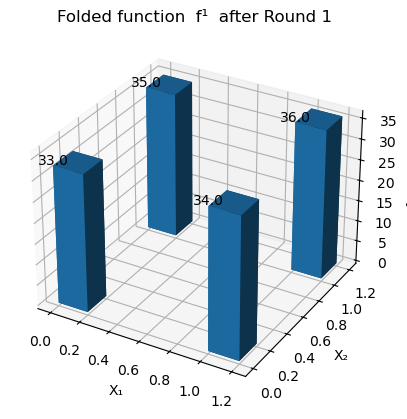

In [71]:
import random
random.seed(int(12345))        # deterministic for the demo

# verifier samples α₀
alpha0 = random.randint(2, 9)
print(f"Verifier samples  α₀ = {alpha0}")

# fold the vector:  f¹(x₁,x₂) = f(α₀, x₁, x₂) 
# even half  = indices where X₀ = 0   (0,1,2,3)
# odd  half  = indices where X₀ = 1   (4,5,6,7)
f_even = f_vec[0:4]
f_odd  = f_vec[4:8]

f_fold = [(1 - alpha0) * e + alpha0 * o     # (1-α)·even + α·odd
          for e, o in zip(f_even, f_odd)]

print("\nFolded 4-point vector  f¹  on the (X₁,X₂) plane:")
for idx, val in enumerate(f_fold):
    print(f"  ({bits_of(idx,2)[0]}, {bits_of(idx,2)[1]})  →  {val}")

from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
xs, ys = zip(*[bits_of(i,2) for i in range(4)])
zs     = f_fold
ax.bar3d(xs, ys, [0]*4, dx=0.2, dy=0.2, dz=zs, shade=True)
for (x, y), z in zip(zip(xs, ys), zs):
    ax.text(x, y, z+0.2, f"{z:.1f}", ha='center')
ax.set_xlabel("X₁"); ax.set_ylabel("X₂"); ax.set_zlabel("f¹ value")
ax.set_title("Folded function  f¹  after Round 1")
plt.show()


In [72]:
# partial sums over X₁
g2_0 = f_fold[0] + f_fold[1]          # X₁ = 0  (indices 00, 01)
g2_1 = f_fold[2] + f_fold[3]          # X₁ = 1  (indices 10, 11)

a2 = g2_0
b2 = g2_1 - g2_0                    

print("\n── Second-round polynomial  h₂(X)  ──")
print(f"h₂(X) = {a2:.1f}  +  {b2:.1f}·X")
print(f"h₂(0) = {a2:.1f}")
print(f"h₂(1) = {a2 + b2:.1f}")
print(f"h₂(2) = {a2 + 2*b2:.1f}")

print(f"a2        = {a2}")
print(f"b2        = {b2}")
print(f"h₂(0)+h₂(1)  = {a2 + (a2 + b2)}")
print(f"Σ f_fold     = {sum(f_fold)}")


# verifier checks the sum relation
assert abs((a2) + (a2 + b2) - sum(f_fold)) < 1e-9
print("Verifier check  h₂(0)+h₂(1)  =  Σ f¹(x)   ✓")



── Second-round polynomial  h₂(X)  ──
h₂(X) = 67.0  +  4.0·X
h₂(0) = 67.0
h₂(1) = 71.0
h₂(2) = 75.0
a2        = 67
b2        = 4
h₂(0)+h₂(1)  = 138
Σ f_fold     = 138
Verifier check  h₂(0)+h₂(1)  =  Σ f¹(x)   ✓


In [73]:
# sample α₁ 
alpha1 = random.randint(2, 9)
print(f"\nVerifier samples  α₁ = {alpha1}")

# fold again over X₁ 
f1_even = f_fold[0:2]                 # X₁ = 0 slice
f1_odd  = f_fold[2:4]                 # X₁ = 1 slice
f_fold2 = [(1 - alpha1) * e + alpha1 * o
           for e, o in zip(f1_even, f1_odd)]     # length 2

print("Folded vector  f²  (depends only on X₂ now):", f_fold2)

# build h₃(X) over the last variable X₂ 
g3_0, g3_1 = f_fold2                  
a3 = g3_0
b3 = g3_1 - g3_0

print("\n── Third-round polynomial  h₃(X)  ──")
print(f"h₃(X) = {a3:.1f}  +  {b3:.1f}·X")
print(f"h₃(0) = {a3:.1f}")
print(f"h₃(1) = {a3 + b3:.1f}")
print(f"h₃(2) = {a3 + 2*b3:.1f}")

# final leaf opening 
alpha2 = random.randint(0, 1)       
leaf   = f_fold2[alpha2]
print(f"\nVerifier picks  α₂ = {alpha2}   and asks for  f²(α₂) = {leaf:.1f}")
assert abs(leaf - (a3 + b3*alpha2)) < 1e-9
print("Leaf equals h₃(α₂)   ✓")

print("\n✅  Sumcheck for n = 3 completed – all rounds verified.\n")



Verifier samples  α₁ = 2
Folded vector  f²  (depends only on X₂ now): [37, 38]

── Third-round polynomial  h₃(X)  ──
h₃(X) = 37.0  +  1.0·X
h₃(0) = 37.0
h₃(1) = 38.0
h₃(2) = 39.0

Verifier picks  α₂ = 1   and asks for  f²(α₂) = 38.0
Leaf equals h₃(α₂)   ✓

✅  Sumcheck for n = 3 completed – all rounds verified.



In [74]:

n = 3
X = sp.symbols(f'X0:{n}')                       # (X0, X1, X2)
f_tilde = sum(coeff * eq_tilde(bits(i, n), X)
              for i, coeff in enumerate(f_vec))

# 2. Evaluate it at the verifier’s random challenges
poly_val = f_tilde.subs({X[0]: alpha0,
                         X[1]: alpha1,
                         X[2]: alpha2})

print("────────────────────────────────────────────")
print(f"f̃(α₀, α₁, α₂) = f̃({alpha0}, {alpha1}, {alpha2})  =  {poly_val}")
print(f"leaf opened in the final Sumcheck round         =  {leaf}")
print("────────────────────────────────────────────")
assert poly_val == leaf
print("✅  They match – Sumcheck transcript is fully consistent.\n")


────────────────────────────────────────────
f̃(α₀, α₁, α₂) = f̃(8, 2, 1)  =  38
leaf opened in the final Sumcheck round         =  38
────────────────────────────────────────────
✅  They match – Sumcheck transcript is fully consistent.



####  What’s still missing after Sumcheck?

At the end of the previous section the verifier is convinced that
$$
\text{leaf} = \sum_{b \in \{0,1\}^3} \text{f\_vec}[b] \cdot \text{eq}(b, \alpha)
$$



…but the verifier has **never seen `f_vec` itself**.
A cheating prover could:

1.  Run Sumcheck with any **fake** vector `f_fake`.
2.  Compute `leaf_fake = Σ f_fake[b]·eq(b, α)` (easy because α is known).
3.  Open that scalar in the last round.

Sumcheck would verify perfectly – yet the statement
“`leaf` equals _your_ polynomial at α” might be **false**.
We therefore need a separate mechanism that binds the prover to
a *single* multilinear polynomial before Sumcheck starts.


In [69]:
#  Cheating prover with *same* total sum  S  but different vector
import random, math

# Choose a fake vector with the same sum 
S_real = sum(f_vec)                        # 36 for [1…8]

print("Honest vector :", f_vec)
n = 3
X = sp.symbols(f'X0:{n}')                       # (X0, X1, X2)
f_tilde = sum(coeff * eq_tilde(bits(i, n), X)
              for i, coeff in enumerate(f_vec))

# 2. Evaluate it at the verifier’s random challenges
poly_val = f_tilde.subs({X[0]: alpha0,
                         X[1]: alpha1,
                         X[2]: alpha2})

print("Expanded polynomial:")
sp.pretty_print(sp.expand(f_tilde))
print("\n")
f_fake_same_sum = list(reversed(f_vec))    # [8,7,6,5,4,3,2,1]
delta = sum(f_fake_same_sum) - S_real      # here 36 - 36 = 0



assert sum(f_fake_same_sum) == S_real and f_fake_same_sum != f_vec

print("Fake vector   :", f_fake_same_sum, "(same sum, different values)")

fake_tilde = sum(coeff * eq_tilde(bits(i, n), X)
              for i, coeff in enumerate(f_fake_same_sum))

# Evaluate it at the verifier’s random challenges
poly_val = fake_tilde.subs({X[0]: alpha0,
                         X[1]: alpha1,
                         X[2]: alpha2})

print("Expanded polynomial:")
sp.pretty_print(sp.expand(fake_tilde))
print("\n")


print("Total sum S   :", S_real, "\n")

def line_triplet(v0, v1):
    return (v0, v1, v0 + 2*(v1 - v0))

def sumcheck_transcript(vec, α0, α1):
    g1_0, g1_1 = sum(vec[:4]), sum(vec[4:])
    h1 = line_triplet(g1_0, g1_1)

    even, odd = vec[:4], vec[4:]
    f_fold = [(1-α0)*e + α0*o for e,o in zip(even, odd)]

    g2_0, g2_1 = f_fold[0]+f_fold[1], f_fold[2]+f_fold[3]
    h2 = line_triplet(g2_0, g2_1)

    even2, odd2 = f_fold[:2], f_fold[2:]
    f_fold2 = [(1-α1)*e + α1*o for e,o in zip(even2, odd2)]

    g3_0, g3_1 = f_fold2
    h3 = line_triplet(g3_0, g3_1)

    α2   = random.randint(0, 1)     
    leaf = eval_line(h3, α2) 
    return h1, h2, h3, α2, leaf

def eval_line(h, x):
    return h[0] + (h[1]-h[0])*x

def verifier_accepts(h1,h2,h3, α0,α1,α2, leaf, S):
    """Return True iff all 4 Sumcheck equalities hold."""
    return (
        math.isclose(h1[0]+h1[1], S) and
        math.isclose(h2[0]+h2[1], eval_line(h1, α0)) and
        math.isclose(h3[0]+h3[1], eval_line(h2, α1)) and
        math.isclose(leaf,          h3[α2])
    )

h1_h, h2_h, h3_h, α2_h, leaf_h = sumcheck_transcript(f_vec,  alpha0, alpha1)
h1_c, h2_c, h3_c, α2_c, leaf_c = sumcheck_transcript(f_fake_same_sum,
                                                     alpha0, alpha1)

print("Verifier challenges: α0 =", alpha0, "α1 =", alpha1, "α2 =", α2_c)
print("Honest leaf =", leaf_h, "   Fake leaf =", leaf_c, "\n")

def poly_str(h):
    """Return 'a + b·X' string for a degree-1 poly given (h0,h1, _)."""
    a, b = h[0], h[1] - h[0]
    return f"{a:.1f}  +  {b:.1f}·X"

def run_and_explain(tag, h1,h2,h3, α0,α1,α2, leaf, S):
    print(f"\n===== Verifier run on {tag} transcript =====")
    print("Prover’s messages:")
    print("  h₁ values =", h1, "  ⇒  h₁(X) =", poly_str(h1))
    print("  h₂ values =", h2, "  ⇒  h₂(X) =", poly_str(h2))
    print("  h₃ values =", h3, "  ⇒  h₃(X) =", poly_str(h3))
    print("  leaf =", leaf, "\n")

    # --- algebraic checks ----------------------------------
    check1 = math.isclose(h1[0] + h1[1], S)
    check2 = math.isclose(h2[0] + h2[1], eval_line(h1, α0))
    check3 = math.isclose(h3[0] + h3[1], eval_line(h2, α1))
    check4 = math.isclose(leaf        , h3[α2])

    print(f"①  h₁(0)+h₁(1) = {h1[0]+h1[1]:>8}    vs  S = {S:<8}        → {check1}")
    print(f"②  h₂(0)+h₂(1) = {h2[0]+h2[1]:>8}    vs  h₁(α₀) = {eval_line(h1,α0):<8}  → {check2}")
    print(f"③  h₃(0)+h₃(1) = {h3[0]+h3[1]:>8}    vs  h₂(α₁) = {eval_line(h2,α1):<8}  → {check3}")
    print(f"④  leaf        = {leaf:>8}    vs  h₃(α₂) = {h3[α2]:<8}       → {check4}")

    all_pass = check1 and check2 and check3 and check4
    print("Result:", "✔ PASSED" if all_pass else "✖ REJECTED")
    return all_pass

ok_honest = run_and_explain("HONEST",
                            h1_h,h2_h,h3_h,
                            alpha0,alpha1,α2_h,
                            leaf_h, S_real)

ok_fake   = run_and_explain("FAKE  ",
                            h1_c,h2_c,h3_c,
                            alpha0,alpha1,α2_c,
                            leaf_c, S_real)   
print("Verifier result on HONEST transcript :", ok_honest)
print("Verifier result on FAKE   transcript :", ok_fake, "\n")

def eval_mle(evals, u):
    return sum(e*eq_tilde(bits_of(i,3), u) for i,e in enumerate(evals))

u_test = (0,0,0)
print(f"At point u = {u_test}:")
print("  honest f̃(u) =", eval_mle(f_vec, u_test))
print("  fake   f̃(u) =", eval_mle(f_fake_same_sum, u_test),
      "← different but still passed Sumcheck!")


Honest vector : [1, 2, 3, 4, 5, 6, 7, 8]
Expanded polynomial:
4⋅X₀ + 2⋅X₁ + X₂ + 1


Fake vector   : [8, 7, 6, 5, 4, 3, 2, 1] (same sum, different values)
Expanded polynomial:
-4⋅X₀ - 2⋅X₁ - X₂ + 8


Total sum S   : 36 

Verifier challenges: α0 = 8 α1 = 2 α2 = 0
Honest leaf = 37    Fake leaf = -28 


===== Verifier run on HONEST transcript =====
Prover’s messages:
  h₁ values = (10, 26, 42)   ⇒  h₁(X) = 10.0  +  16.0·X
  h₂ values = (67, 71, 75)   ⇒  h₂(X) = 67.0  +  4.0·X
  h₃ values = (37, 38, 39)   ⇒  h₃(X) = 37.0  +  1.0·X
  leaf = 37 

①  h₁(0)+h₁(1) =       36    vs  S = 36              → True
②  h₂(0)+h₂(1) =      138    vs  h₁(α₀) = 138       → True
③  h₃(0)+h₃(1) =       75    vs  h₂(α₁) = 75        → True
④  leaf        =       37    vs  h₃(α₂) = 37             → True
Result: ✔ PASSED

===== Verifier run on FAKE   transcript =====
Prover’s messages:
  h₁ values = (26, 10, -6)   ⇒  h₁(X) = 26.0  +  -16.0·X
  h₂ values = (-49, -53, -57)   ⇒  h₂(X) = -49.0  +  -4.0·X
  h₃ values